#Required python libraries



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from math import tanh, exp, sqrt, pi, log2, floor

# Define helper functions

In [30]:
def convertobin(sbin):
    bin_array = np.zeros(len(sbin), dtype=int)  # Creates an array of zeros with the same length as the input string

    for i in range(len(sbin)):
        if sbin[i] == '0':
            bin_array[i] = 0
        else:
            bin_array[i] = 1

    return bin_array

def convertobininv(sbin):
    aux = len(sbin)
    bin2 = np.zeros(aux, dtype=int)  # Creates an array of zeros with the same length as the input string

    for i in range(aux):
        if sbin[i] == '0':
            bin2[aux-i-1] = 0
        else:
            bin2[aux-i-1] = 1

    return bin2

def logF(ra, rb):
    if ra < rb:
        r = rb + math.log(1 + np.exp(ra - rb))
    else:
        r = ra + math.log(1 + np.exp(rb - ra))

    return r

def funcao_F(la, lb):
    F = logF(la + lb, 0) - logF(la, lb)
    return F

def funcao_G(la, lb, retro):
    if retro == 0:
        G = la + lb
    else:
        G = la - lb

    return G

def auxCol(N):
    N = 2 ** math.ceil(math.log2(N))
    aux = N - 1
    n = int(math.log2(N))
    col = np.zeros(N, dtype=int)  # Creates an array of zeros with size N

    for j in range(1, N+1):
        col[j-1] = np.sum(np.logical_xor(convertobin(format(j-1, 'b').zfill(n)), convertobin(format(aux, 'b').zfill(n)))) - 1
        aux = j - 1

    return col

def fbitreversed(j, n):
    i = np.zeros(len(j), dtype=int)

    if n == 0:
        n = 1

    for indx in range(len(j)):
        x = format(j[indx], f'0{n}b')
        y = x[::-1]
        i[indx] = int(y, 2) + 1

    return i

def montaMapa(N):
    N = 2 ** math.ceil(math.log2(N))
    n = int(math.log2(N))
    mp = np.zeros((N, n), dtype=int)
    sequencia_W = fbitreversed(np.arange(N), n)

    for j in range(N):
        i = sequencia_W[j]
        mp[j, :] = convertobininv(format(i-1, f'0{n}b'))

    return mp

def MatrizGeradora(N, tipo=1):
    if N == 1:
        G = np.array([[1]])
        return G

    N = 2 ** math.ceil(math.log2(N))
    f = np.array([[1, 0], [1, 1]])
    G = f
    dimensao = int(math.log2(N))

    for i in range(1, dimensao):
        G = np.kron(G, f)

    if tipo == 2:
        indices_bitreversed = np.arange(N)
        indices_bitreversed = np.array([int(format(i, f'0{dimensao}b')[::-1], 2) for i in indices_bitreversed])
        G = G[indices_bitreversed]

    return G

def GeraIndexRETRO(N):
    N = 2 ** math.ceil(math.log2(N))
    n = int(math.log2(N))
    ind_retro = np.zeros((N//2, n), dtype=int)
    aux_ind_retro = ind_retro.copy()

    for i in range(1, n+1):
        aux_ind_retro[:2**(n-i), i-1] = np.arange(1, 2**(n-i) + 1)

    for i in range(1, n+1):
        aux = aux_ind_retro[:2**(n-i), i-1] - 1
        ind_retro[:2**(n-i), i-1] = fbitreversed(aux, n-i)

    return ind_retro

def f_APGA(x):
    if x <= 0.2:
        y = 0.322560028160692 * x**2
    elif x <= 1:
        y = (-0.100100552321857 * x**3 +
             0.430275615544323 * x**2 -
             0.038487434046164 * x -
             0.004441028103629)
    elif x <= 6:
        y = (-0.002929804669861 * x**3 +
             0.062992555926568 * x**2 +
             0.432194236372939 * x -
             0.200255447812440)
    elif x <= 20:
        y = (-0.000230527351771 * x**3 +
             0.011990524520852 * x**2 +
             0.776651672458771 * x -
             1.023478285142636)
    else:
        y = 0.980357170207872 * x - 2.108910937251202
    return y

def polarizacao(N, K, designSNRdB=0):
    colunas = int(math.log2(N))
    linhas = N
    W = np.zeros((linhas, colunas+1))
    #designSNR = 10**(designSNRdB/10)
    #W[0, 0] = -designSNR  # In logdomain: actual initial Bh.Param = exp(-Ec/N0)

    R = K/N
    EdB = designSNRdB
    S = R*10**(EdB/10)
    W[0, 0] = 4*S

    for i in range(2, colunas+2):
        aux = 2**(i-1) // 2
        pos_linha = 0

        for j in range(aux):
#            W[pos_linha, i-1] = np.log(2) + W[j, i-2] + np.log(1 - np.exp(2*W[j, i-2] - (np.log(2) + W[j, i-2])))  # domain log
#            W[pos_linha+1, i-1] = 2 * W[j, i-2]  # domain log
            W[pos_linha, i-1] = f_APGA(W[j, i-2])
            W[pos_linha+1, i-1] = 2 * W[j, i-2]  # domain log
            pos_linha += 2
    #print(W)
    aux = fbitreversed(np.arange(N), colunas)
    W0 = W[:, colunas]

    W_aux = np.zeros(N, dtype=float)
    for r in range(N):
        W_aux[r] = W0[aux[r]-1]

    rank = np.argsort(W_aux, axis=0)
    P = np.zeros(N, dtype=int) + 2

    for j in range(K):
        P[rank[j]] = 0  # marker of frozen positions

    return P

def calculaRETRO(u, W, MatrizG, retro, contador):
    cont_canal = W+1
    N = len(u)
    n = int(math.log2(N))
    flag = np.ones(n, dtype=int)
    i = cont_canal
    contador -= 1
    aux = 0

    for s in range(n, 0, -1):
        aux += 1
        if contador[s-1] == 0:
            if flag[s-1] == 1:
                inicio = i - ((2**(aux-1)) - 1) - 1
                tempG = MatrizG[:2**(aux-1), :2**(aux-1)]
                tempu = u[inicio:i]
                tempr = np.mod(np.dot(tempu, tempG), 2)
                retro[:2**(aux-1), s-1] = tempr
                contador[s-1] = 2**(aux-1)
                flag[s-1] = 0
            else:
                contador[s-1] = 2**(aux-1)
                flag[s-1] = 1

    R = retro
    cont = contador
    return R, cont

def calculaLLR(N, mapa, retro, aux_col, LLR, IndexRETRO):
    colunas = int(math.log2(N))
    linhas = N
    inic_colunas = (colunas+1) - aux_col

    for i in range(inic_colunas, colunas+2):
        aux = linhas // 2**(i-1)
        pos_linha = 0

        for j in range(1, aux+1):
            if mapa[i-2] == 0:
                LLR[j-1, i-1] = funcao_F(LLR[pos_linha, i-2], LLR[pos_linha+1, i-2])
            else:
                r = IndexRETRO[j-1, i-2] - 1
                LLR[j-1, i-1] = funcao_G(LLR[pos_linha+1, i-2], LLR[pos_linha, i-2], retro[r, i-2])

            pos_linha += 2

    R = LLR
    return R

def codificador(m, P, G, tipo=1):
    if tipo == 1:
        pre_c = np.zeros(G.shape[1], dtype=int)
        pre_c[P == 2] = m
        c = np.mod(np.dot(pre_c, G), 2)
    elif tipo == 2:
        mascara = np.ones(G.shape[1], dtype=int)
        mascara[P == 2] = 0
        pre_c = np.logical_and(m, mascara).astype(int)
        c = np.mod(np.dot(pre_c, G), 2)
    else:
        raise ValueError("The value of 'type' must be either 1 (non-systematic coding) or 2 (systematic coding).")

    return c

def decodificador(y, N, Ec, N0, polarizacao, IndexRETRO, MatrizG, aux_col, mapa, sequencia_W, tipo=1):
    initialLRs = -(4 * math.sqrt(Ec) / N0) * y
    du = np.zeros(N, dtype=int)
    ru = np.zeros(N, dtype=int)
    n = int(math.log2(N))
    retro = np.zeros((N//2, n), dtype=int)
    contador = 2 ** (np.arange(n-1, -1, -1))
    LLR = np.zeros((N, n+1))
    LLR[:, 0] = initialLRs
    aux_LLR = np.zeros(N, dtype=float)
    for j in range(N):
        i = sequencia_W[j]-1
        LLR = calculaLLR(N, mapa[j, :], retro, aux_col[j], LLR, IndexRETRO)  # calculates the evolution of LLR
        aux_LLR[i] = LLR[0, n]
        if polarizacao[i] == 2:
            if LLR[0, n] > 0:
                du[i] = 0
            else:
                du[i] = 1
        else:
            du[i] = 0
        ru[j] = du[i]
        retro, contador = calculaRETRO(ru, j, MatrizG, retro, contador)  # calculates LLR feedback matrix
    u = du[polarizacao == 2]
    if tipo == 2:
        du = codificador(u, polarizacao, MatrizG, 1)
        u = du[polarizacao == 2]

    return u


def f(u,x):
    # The term sqrt(4*pi*x) suggests x should be non-negative.
    # This function is likely intended for the Bhattacharyya parameter, which is between 0 and 1.
    # For stability with very small x, handle the sqrt(x) in denominator.
    if x < 1e-9: # Adding a small epsilon to avoid division by zero or near-zero
         return 0 # Or handle according to the function's definition for x=0
    return (1 / sqrt(4 * pi * x)) * tanh(u / 2) * exp(-((u - x) ** 2) / (4 * x))


def f_EGA(x):
    # x here should represent the probability domain parameter (between 0 and 1)
    if x == 0:
        return 1.0
    else:
        # Ensure the input to trapezoidal is also in the probability domain if needed,
        # or if trapezoidal expects a different domain, convert accordingly.
        # Given the error was in sqrt(2*x) in trapezoidal, x likely was expected to be non-negative.
        # Assuming x in f_EGA is the probability parameter (0 to 1), sqrt(2*x) is fine.
        # The issue was passing a negative log-domain parameter.
        return 1 - trapezoidal(x)

def trapezoidal(x):
    n = 100
    # Here x should be in the probability domain (0 to 1) to avoid sqrt of negative.
    # If the log-domain value was passed to f_EGA and then here, this is where the error happens.
    # Assuming x here is in [0, 1] as it's from f_EGA which takes a probability parameter.
    # The issue is likely the input to f_EGA being a negative log-domain value.
    # We should pass a probability value to f_EGA.
    a = x - 4 * sqrt(2 * x)
    b = x + 4 * sqrt(2 * x)
    h = (b - a) / n
    result = 0.5 * f(a,x) + 0.5 * f(b,x)
    for i in range(1, n):
        result += f(a + i * h,x)
    return h * result

def f_EGA_inv(y):
    aux = 1.0
    base = f_EGA(aux)
    iteration_times = 50

    if y >= base:
        while y > base and aux > 1e-9: # Add a lower bound check for aux
            aux *= 1e-1
            base = f_EGA(aux)
        anchor_1 = aux
        anchor_2 = aux * 10
    else:
        while y < base:
            aux += 10
            base = f_EGA(aux)
        anchor_1 = aux - 10
        anchor_2 = aux

    for _ in range(iteration_times):
        x = (anchor_1 + anchor_2) / 2
        if y >= f_EGA(x):
            anchor_2 = x
        else:
            anchor_1 = x
    return (anchor_1 + anchor_2) / 2

def polarizacao2(N, K, designSNRdB=0):
    colunas = int(math.log2(N))
    linhas = N
    W = np.zeros((linhas, colunas+1))
    designSNR = 10**(designSNRdB/10)
    W[0, 0] = -designSNR  # In logdomain: actual initial Bh.Param = exp(-Ec/N0)

    for i in range(2, colunas+2):
        aux = 2**(i-1) // 2
        pos_linha = 0

        for j in range(aux):
            z_param = np.exp(-np.abs(W[j, i-2])/2) # Convert log-domain to Z parameter

            # Apply the EGA evolution rule in the probability domain (on Z)
            temp_z = 1 - (1 - f_EGA(z_param))**2

            if W[j, i-2] < -700: # Approximation for np.exp very close to 0
                p_param = 1.0
            else:
                p_param = 1 / (1 + np.exp(W[j, i-2]))

            z_param = np.exp(-np.abs(W[j, i-2]) / 2)

            code_rate = K / N
            linear_EbN0 = 10**(designSNRdB/10)
            initial_Z = np.exp(-code_rate * linear_EbN0)

            # Initialize W[0,0] with the initial Bhattacharyya parameter (non-negative)
            W[0, 0] = initial_Z # W now stores Z parameters

            for i in range(2, colunas+2):
                aux = 2**(i-1) // 2
                pos_linha = 0

                for j in range(aux):
                    # W[j, i-2] is the Z parameter of the parent channel (non-negative)
                    z_parent = W[j, i-2]

                    # Calculate the intermediate values using f_EGA
                    term_fega = f_EGA(z_parent)

                    # Calculate the Z parameter for channel f
                    arg_inv_f = 1 - (1 - term_fega)**2
                    # Clamp the argument to f_EGA_inv to be within a valid range [epsilon, 1]
                    # since f_EGA_inv expects values in [0, 1) (from the range of 1-trapezoidal).
                    arg_inv_f = np.clip(arg_inv_f, 1e-9, 1.0 - 1e-9) # Avoid log(0) or log(negative) in inverse

                    W[pos_linha, i-1] = f_EGA_inv(arg_inv_f) # W stores Z parameters

                    # Calculate the Z parameter for channel g
                    arg_inv_g = term_fega**2
                     # Clamp the argument to f_EGA_inv to be within a valid range [epsilon, 1]
                    arg_inv_g = np.clip(arg_inv_g, 1e-9, 1.0 - 1e-9)

                    W[pos_linha+1, i-1] = f_EGA_inv(arg_inv_g) # W stores Z parameters

                    pos_linha += 2

            # W[:, colunas] now contains the Z parameters for all N channels.
            # Sort based on Z parameters (smaller Z is better channel)
            aux = fbitreversed(np.arange(N), colunas)
            W0 = W[:, colunas] # These are Z parameters

            W_aux = np.zeros(N, dtype=float)
            channel_z_values = np.zeros(N, dtype=[('z', float), ('index', int)])
            for r in range(N):
                # W0[r] is the Z value for the channel that ends up at position r in the polarization tree output.
                # The bitreversed index aux[r] is the *original* index of that channel.
                original_index = aux[r] - 1 # convert 1-based to 0-based
                channel_z_values[original_index] = (W0[r], original_index)

            # Sort by Z value (ascending)
            rank = np.argsort(channel_z_values['z'])

            P = np.zeros(N, dtype=int)

            for j in range(K):
                info_channel_original_index = rank[j]
                P[info_channel_original_index] = 2  # Mark as non-frozen (information)

            return P


#BER and FER polar codes performance

Elapsed time:  14.908741235733032  seconds




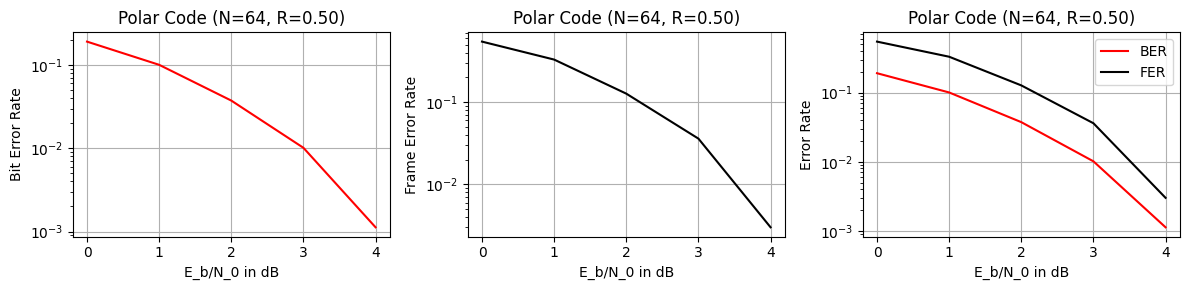

In [31]:
# Parameters
N_example = 64
K_example = 32
designSNRdB_example = 0
EbN0dB = np.arange(0, 4+1, 1)  # Signal-to-noise ratio in dB
Ec_example = 1
N0_example = 2
MCsize = 1000  # Number of simulations

# Initializing arrays to store results
BER = np.zeros(len(EbN0dB))
FER = np.zeros(len(EbN0dB))

Nout = N_example
N_example = 2**int(math.ceil(math.log2(N_example)))

IndexRETRO = GeraIndexRETRO(N_example)
aux_col = auxCol(N_example)
mapa = montaMapa(N_example)
sequencia_W = fbitreversed(np.arange(2**int(math.ceil(math.log2(N_example)))), int(math.ceil(math.log2(N_example))))
P = polarizacao(N_example, K_example, designSNRdB_example)
G = MatrizGeradora(N_example)
start_time = time.time()
for j in range(len(EbN0dB)):
    Ec_example = (K_example / N_example) * N0_example * 10**(EbN0dB[j] / 10)

    for l in range(1, MCsize+1):
        u = (np.random.rand(K_example) > 0.5).astype(int)
        x = codificador(u, P, G, tipo=1)
        txvec = (2*x - 1) * math.sqrt(Ec_example)
        y = txvec + np.random.randn(N_example) * math.sqrt(N0_example / 2)

        uhat = decodificador(y, N_example, Ec_example, N0_example, P, IndexRETRO, G, aux_col, mapa, sequencia_W, tipo=1)

        nfails = np.sum(uhat != u)
        FER[j] += int(nfails > 0)
        BER[j] += nfails

    FER[j] /= MCsize
    BER[j] /= (K_example * MCsize)

# End of time count
end_time = time.time()
# Calculation of elapsed time
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time, " seconds")

# Printing chart
print('\n')
titlestr = f'Polar Code (N={Nout}, R={K_example/Nout:.2f})'
plt.figure(1, figsize=(12, 3))

plt.subplot(131)
plt.semilogy(EbN0dB, BER, '-r')
plt.title(titlestr)
plt.xlabel('E_b/N_0 in dB')
plt.ylabel('Bit Error Rate')
plt.grid(True)
plt.subplot(132)
plt.semilogy(EbN0dB, FER, '-k')
plt.title(titlestr)
plt.xlabel('E_b/N_0 in dB')
plt.ylabel('Frame Error Rate')
plt.grid(True)
plt.subplot(133)
plt.semilogy(EbN0dB, BER, '-r')
plt.semilogy(EbN0dB, FER, '-k')
plt.title(titlestr)
plt.xlabel('E_b/N_0 in dB')
plt.ylabel('Error Rate')
plt.legend(['BER', 'FER'])
plt.grid(True)
plt.tight_layout()
plt.show()
